# First section is to show when tweets happen 

Notice periodic behaviour

TODO: Clean plot/visualize it differently to show when the most popular tweeting hours/days are. Topic/Sentiment analysis on those days??? 

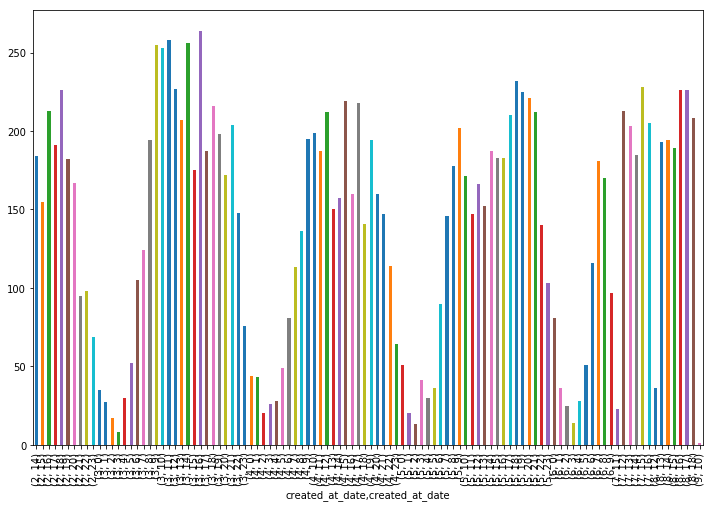

In [7]:
import pandas as pd
import urllib.request
import ast
import pandas as pd 

target_url="https://swift-yeg.cloud.cybera.ca:8080/v1/AUTH_233e84cd313945c992b4b585f7b9125d/geeky-summit/tweets_cleaned.csv"
file_name="tweets_cleaned.csv"
urllib.request.urlretrieve(target_url, file_name)

df = pd.read_csv(file_name,parse_dates=['created_at_date']) 
import matplotlib.pyplot as plt
%matplotlib inline
#df.groupby([times.hour, times.minute]).value_col.sum()
df.created_at_date= df.created_at_date.dt.tz_localize('UTC').dt.tz_convert('MST')
df['created_at_date'].groupby([
            df.created_at_date.dt.day, 
            df.created_at_date.dt.hour
    ]).count().plot(kind="bar", figsize = (12,8))

In [96]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
def compoundSentiment(row):
    score = analyser.polarity_scores(row.extended_tweet_cleaned)
    return score['compound']

df['score'] = df.apply(compoundSentiment, axis=1)

df.head()

,created_at_date,hashtags_string,user_string,user_location,lang,longitude,latitude,name,screen_name,extended_tweet,extended_tweet_cleaned,score
0,2018-11-02 14:01:56-07:00,,Symin16,Toronto ✈ Calgary,en,NaN,NaN,♠,jessmayumba85,@Symin16 I’d like to know who,I’d like to know who,0.3612
1,2018-11-02 14:02:01-07:00,,TwoCanSamAdams,YYC,en,NaN,NaN,hannahrae cuddleslug,thimblewad,@TwoCanSamAdams Legit. There are still chunks ...,Legit. There are still chunks in the sink an...,-0.2263
2,2018-11-02 14:02:05-07:00,job Calgary SupplyChain Hiring CareerArc,,Calgary,en,51.004583,-114.007914,TMJ - CAL Manuf Jobs,tmj_cal_manuf,Can you recommend anyone for this #job in #Cal...,"Can you recommend anyone for this in , AB? ...",0.3612
3,2018-11-02 14:02:10-07:00,,,🌎📱,en,NaN,NaN,Sunny Rai,TheSunsRay,Kids See Ghosts: love this track,Kids See Ghosts: love this track,0.6369
4,2018-11-02 14:02:13-07:00,Calgary job,,Calgary,en,50.997882,-114.074005,TMJ-CAL Retail Jobs,tmj_cal_retail,"See our latest #Calgary, AB #job and click to ...","See our latest , AB and click to apply: bar...",0.0000


# Sentiment Analysis

Note all the cleaning (removing duplicate and things with coordinates (Those are typically adds TODO: Prove this) ) 

TODO: Find sentiment around a topic or something along those lines, however after cleaning we can probably start to find things in there. 

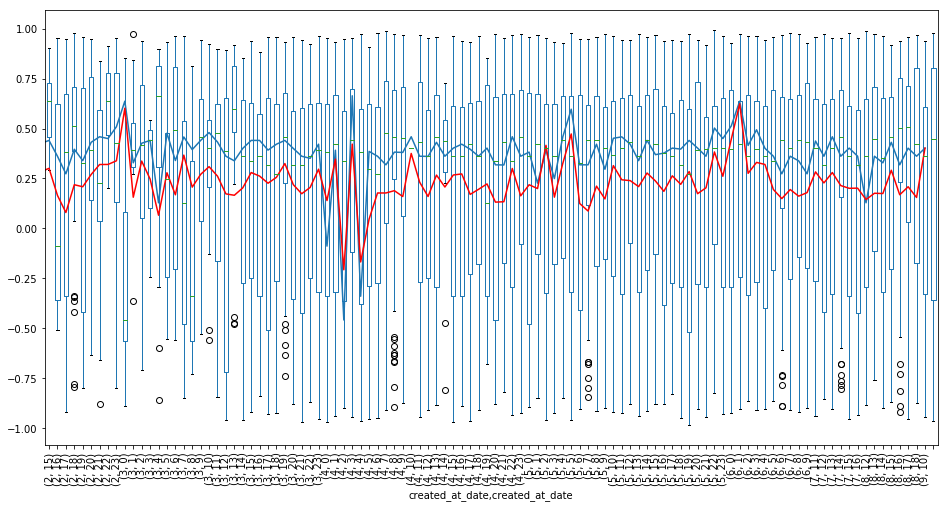

In [55]:
import seaborn as sns
s_df = df.drop_duplicates(subset='extended_tweet_cleaned', keep="last")
s_df = s_df[s_df.score !=0]
s_df = s_df[s_df.latitude.isnull()]
# sentiment_df = sentiment_df[sentiment_df.coordinates.isnull()]
median = s_df[['score', 
             'created_at_date']].groupby(
                            by=[
                                s_df.created_at_date.dt.hour, 
                                s_df.created_at_date.dt.day],
                            as_index=False)

ax = median['score'].boxplot(subplots=False, figsize = (16,8), rot = 90)
ax = s_df['score'].groupby([s_df.created_at_date.dt.day, 
                           s_df.created_at_date.dt.hour]).median().plot(kind='line', rot=90)

ax = s_df['score'].groupby([s_df.created_at_date.dt.day,
                           s_df.created_at_date.dt.hour]).mean().plot(kind='line', rot=90, color='r')


In [54]:
import numpy as np

TODO: scale this right so you can talk about potential periodic signals in the sentiment (you'll need to scale by sampling rate, when we aggregate that sampling rate is once an hour)

That said I don't think this actually shows anything as it assumes periodic signals because its an FFT and I think what we're seeing here is incomplete/we probably can't see it appropriatly. I'll probably cut this if I'm being completely honest. 

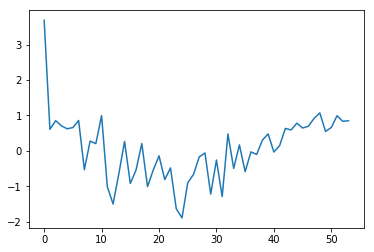

In [95]:
points = s_df['score'].groupby([s_df.created_at_date.dt.day, 
                           s_df.created_at_date.dt.hour]).median()
Y = np.fft.rfftn(points) # fft computing and normalization
# Y = pd.Series(Y)
# df['fft'] = Y.values

plt.plot(np.log(np.abs(Y)))


# TODO: Sentiment of a topic? 